In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
# Set random seed
np.random.seed(123)

In [107]:
# Simulation parameters
N = 10000           # number of individuals
trend = 1.0         # common time effect
beta = 2.0          # causal effect of treatment

In [109]:
# Simulate the continuous treatment D which includes negative and positive values.
D = np.random.normal(0, 1, N)

In [111]:
# Simulate individual fixed effects 
alpha = np.random.normal(0, 1, N)

In [113]:
# Generate errors for period 1 and period 2 -- random noise, uncorrelated
epsilon1 = np.random.normal(0, 1, N)
epsilon2 = np.random.normal(0, 1, N)

In [141]:
# Period 1: pre-treatment: only individual effects and epsilon.
Y1 = alpha + epsilon1

# Period 2: post-treatment: common shift plus the treatment effect (D * Beta) plus individual effects and noise. 
# D * Beta ensures continuous treatment of both positive and negative
Y2 = alpha + trend + beta * D + epsilon2

In [117]:
# Calculate the change in outcome for each individual (Treatment Impact)
DeltaY = Y2 - Y1

In [119]:
# Organize Data and Dataframe
data = pd.DataFrame({'D': D, 'Y1': Y1, 'Y2': Y2, 'DeltaY': DeltaY})

In [167]:
# Reference dose, d_ref = 0.
d_ref = 0

In [139]:
# Bin the treatment into 30 bins. Allows me to approx. the condition expectation E[deltaY | D = d]
bins = np.linspace(np.min(D), np.max(D), 30) # Creates 30 equally spaced bins across D
data['D_bin'] = pd.cut(data['D'], bins) # Each individuals treatment is put into a bin

In [125]:
# Compute the average DeltaY for each bin, essentially the E[deltaY | D = in bin]
# Calculates the mean treatment level within bin, and the mean change in outcome within bin
grouped = data.groupby('D_bin').agg({'D': 'mean', 'DeltaY': 'mean'}).reset_index(drop=True)

In [161]:
# Now, let’s compute the difference in average DeltaY between each bin and the reference bin.
# We need to find the bin that is closest to the reference dose d_ref.
ref_bin = grouped.iloc[(grouped['D'] - d_ref).abs().argsort()[:1]] # Computes the absolute difference between the average treatment level in each 
# bin and the reference dose, finding the bin with the smallest difference
d_ref_mean = ref_bin['D'].values[0] # Store average treatment level of reference bin
DeltaY_ref = ref_bin['DeltaY'].values[0] # Store average deltaY for reference bin

In [163]:
# The difference in average DeltaY between each bin and ref bin: this is the observed difference in outcomes relative to reference treatment level
grouped['DeltaY_diff'] = grouped['DeltaY'] - DeltaY_ref
# The theoretical difference:
grouped['theoretical_diff'] = beta * (grouped['D'] - d_ref_mean)

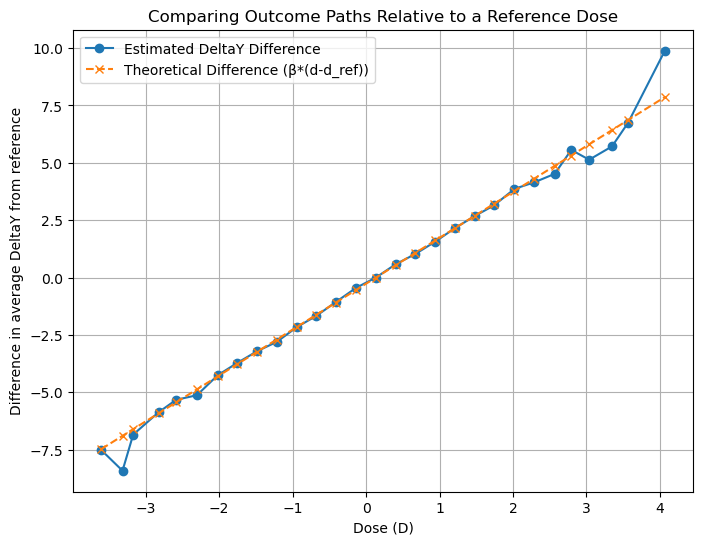

           D     DeltaY  DeltaY_diff  theoretical_diff
0  -3.606177  -6.234761    -7.519907         -7.482524
1  -3.316010  -7.138379    -8.423525         -6.902189
2  -3.170774  -5.563800    -6.848946         -6.611716
3  -2.825972  -4.591955    -5.877101         -5.922112
4  -2.585703  -4.046593    -5.331739         -5.441575
5  -2.303786  -3.847379    -5.132525         -4.877740
6  -2.021685  -2.980351    -4.265497         -4.313538
7  -1.755129  -2.441279    -3.726425         -3.780428
8  -1.484745  -1.929364    -3.214510         -3.239659
9  -1.216430  -1.522882    -2.808028         -2.703028
10 -0.941313  -0.875082    -2.160228         -2.152794
11 -0.676689  -0.386318    -1.671464         -1.623546
12 -0.410749   0.217756    -1.067390         -1.091666
13 -0.135563   0.835572    -0.449574         -0.541296
14  0.135084   1.285146     0.000000          0.000000
15  0.402323   1.862086     0.576939          0.534478
16  0.672931   2.314676     1.029530          1.075693
17  0.9426

In [131]:
# Plot the estimated difference versus the theoretical difference.
plt.figure(figsize=(8, 6))
plt.plot(grouped['D'], grouped['DeltaY_diff'], marker='o', linestyle='-', label='Estimated DeltaY Difference')
plt.plot(grouped['D'], grouped['theoretical_diff'], marker='x', linestyle='--', label='Theoretical Difference (β*(d-d_ref))')
plt.xlabel('Dose (D)')
plt.ylabel('Difference in average DeltaY from reference')
plt.title('Comparing Outcome Paths Relative to a Reference Dose')
plt.legend()
plt.grid(True)
plt.show()

# Additionally, you can print the grouped table for inspection
print(grouped[['D', 'DeltaY', 'DeltaY_diff', 'theoretical_diff']])

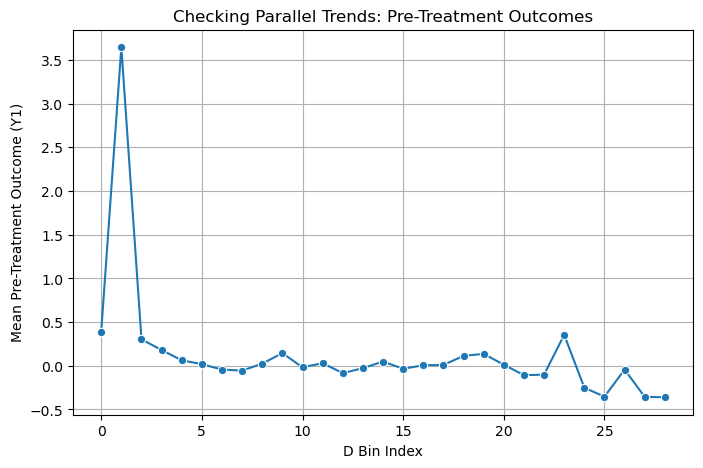

In [133]:
# Bin data into groups based on D
data['D_bin'] = pd.cut(data['D'], bins)

# Compute pre-treatment means for each bin
pre_trends = data.groupby('D_bin').agg({'Y1': 'mean'}).reset_index()

# Plot pre-treatment means
plt.figure(figsize=(8, 5))
sns.lineplot(x=pre_trends.index, y=pre_trends['Y1'], marker='o')
plt.xlabel("D Bin Index")
plt.ylabel("Mean Pre-Treatment Outcome (Y1)")
plt.title("Checking Parallel Trends: Pre-Treatment Outcomes")
plt.grid(True)
plt.show()
